In [ ]:
# pip install "dask[dataframe]"

In [ ]:
import xarray as xr

# Create a dummy dataset with some NaN values
ds = xr.Dataset({'data1': (['x', 'y'], [[1, 2], [3, 4]]),
                 'data2': (['x', 'y'], [[1, float('nan')], [float('nan'), 4]])})

var_names = list(ds.data_vars.keys())
for var_name in var_names:
    da = ds[var_name]
    null_count = da.size - da.count()
    if null_count.values > 0:
        print(f"The DataArray for {var_name} has {null_count.values} null values.")
        break

In [ ]:
list(ds.data_vars.keys())

In [ ]:
filename = "../data/NWP/ERA5_to_merge/RJ_" + str(1997) + ".nc"
ds = xr.open_dataset(filename)
ds

In [ ]:
ds

# Slice from 1997 to 2020 (pressure_level in [700, 1000])

In [1]:
import pandas as pd
import xarray as xr

ds = None
df = None
for year in range (1997, 2021):
    print(f">>>Year: {year}")
    filename = "../data/NWP/ERA5_to_merge/RJ_" + str(year) + ".nc"
    ds = xr.open_dataset(filename)

    var_names = list(ds.data_vars.keys())
    for var_name in var_names:
        da = ds[var_name]
        null_count = da.size - da.count()
        if null_count.values > 0:
            print(f"The DataArray for {var_name} has {null_count.values} null values.")
            break

    # see https://confluence.ecmwf.int/display/CUSF/ERA5+CDS+requests+which+return+a+mixture+of+ERA5+and+ERA5T+data
    if "expver" in list(ds.coords.keys()):
        print(">>>Oops! expver dimension found. Going to remove it.<<<")
        ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
        ds_combine.load()
        ds = ds_combine

    print(f"File {filename} successfuly opened. Size: {ds.sizes['time']}")
    time_min = ds.time.min().values
    time_max = ds.time.max().values
    print(f"Range of timestamps: [{time_min}, {time_max}]")
    df_aux = ds.to_dataframe()
    if ds is None:
        df = df_aux
    else:
        df = pd.concat([df, df_aux])

filename = "../data/NWP/ERA5_at_700_1000.parquet.gzip"
print(f"Saving dowloaded data to {filename}")
df.to_parquet(filename, compression='gzip')

>>>Year: 1997
File ../data/NWP/ERA5_to_merge/RJ_1997.nc successfuly opened. Size: 8760
Range of timestamps: [1997-01-01T00:00:00.000000000, 1997-12-31T23:00:00.000000000]
>>>Year: 1998
File ../data/NWP/ERA5_to_merge/RJ_1998.nc successfuly opened. Size: 8760
Range of timestamps: [1998-01-01T00:00:00.000000000, 1998-12-31T23:00:00.000000000]
>>>Year: 1999
File ../data/NWP/ERA5_to_merge/RJ_1999.nc successfuly opened. Size: 8760
Range of timestamps: [1999-01-01T00:00:00.000000000, 1999-12-31T23:00:00.000000000]
>>>Year: 2000
File ../data/NWP/ERA5_to_merge/RJ_2000.nc successfuly opened. Size: 8784
Range of timestamps: [2000-01-01T00:00:00.000000000, 2000-12-31T23:00:00.000000000]
>>>Year: 2001
File ../data/NWP/ERA5_to_merge/RJ_2001.nc successfuly opened. Size: 8760
Range of timestamps: [2001-01-01T00:00:00.000000000, 2001-12-31T23:00:00.000000000]
>>>Year: 2002
File ../data/NWP/ERA5_to_merge/RJ_2002.nc successfuly opened. Size: 8760
Range of timestamps: [2002-01-01T00:00:00.000000000, 2002-

In [ ]:
import pandas as pd
filename = "../data/NWP/ERA5_all_700_1000.parquet.gzip"
df = pd.read_parquet(filename)

In [ ]:
df.head()

In [ ]:
df.tail()

# Slice from 1997 to 2020 (pressure_level in [200])

In [2]:
import xarray as xr

def merge_files_from_1997_to_2020_at_200hPa():
    df_all = None
    for year in range (1997, 2020, 2):
        print(f"years: {year}-{year+1}")

        filename = "../data/NWP/ERA5_to_merge/RJ_" + str(year) + "_" + str(year+1) + "_200.nc"
        ds = xr.open_dataset(filename)
        print(f"File {filename} successfuly opened. Size: {ds.sizes['time']}")

        var_names = list(ds.data_vars.keys())
        for var_name in var_names:
            da = ds[var_name]
            null_count = da.size - da.count()
            if null_count.values > 0:
                print(f"!!!The DataArray for {var_name} has {null_count.values} null values.!!!")
                return

        # see https://confluence.ecmwf.int/display/CUSF/ERA5+CDS+requests+which+return+a+mixture+of+ERA5+and+ERA5T+data
        if "expver" in list(ds.coords.keys()):
            print(">>>Oops! expver dimension found. Going to remove it.<<<")
            ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
            ds_combine.load()
            ds = ds_combine
        
        df = ds.to_dataframe()
        time_min = ds.time.min().values
        time_max = ds.time.max().values
        print(f"Range of timestamps: [{time_min}, {time_max}]")

        # Add a new level called 'level' with a value of 200
        new_level = pd.Index([200] * len(df.index), name='level')
        new_index = pd.MultiIndex.from_arrays([df.index.get_level_values('longitude'),
                                                   df.index.get_level_values('latitude'),
                                                   new_level,
                                                   df.index.get_level_values('time')])
        df.index = new_index
        
        if df_all is None:
            df_all = df
        else:
            df_all = pd.concat([df_all, df])
        
        print()

    filename = "../data/NWP/ERA5_at_200hPa.parquet.gzip"
    print(f"Saving resulting data to {filename}")
    df_all.to_parquet(filename, compression='gzip')
    return df_all

df = merge_files_from_1997_to_2020_at_200hPa()

years: 1997-1998
File ../data/NWP/ERA5_to_merge/RJ_1997_1998_200.nc successfuly opened. Size: 17520
Range of timestamps: [1997-01-01T00:00:00.000000000, 1998-12-31T23:00:00.000000000]

years: 1999-2000
File ../data/NWP/ERA5_to_merge/RJ_1999_2000_200.nc successfuly opened. Size: 17544
Range of timestamps: [1999-01-01T00:00:00.000000000, 2000-12-31T23:00:00.000000000]

years: 2001-2002
File ../data/NWP/ERA5_to_merge/RJ_2001_2002_200.nc successfuly opened. Size: 17520
Range of timestamps: [2001-01-01T00:00:00.000000000, 2002-12-31T23:00:00.000000000]

years: 2003-2004
File ../data/NWP/ERA5_to_merge/RJ_2003_2004_200.nc successfuly opened. Size: 17544
Range of timestamps: [2003-01-01T00:00:00.000000000, 2004-12-31T23:00:00.000000000]

years: 2005-2006
File ../data/NWP/ERA5_to_merge/RJ_2005_2006_200.nc successfuly opened. Size: 17520
Range of timestamps: [2005-01-01T00:00:00.000000000, 2006-12-31T23:00:00.000000000]

years: 2007-2008
File ../data/NWP/ERA5_to_merge/RJ_2007_2008_200.nc success

In [ ]:
df.head()

In [ ]:
df.tail()

# Merging from 1997 to 2020 ([200] + [700, 1000])

In [3]:
df_200 = pd.read_parquet("../data/NWP/ERA5_at_200hPa.parquet.gzip")
df_200.tail()

z          r  \
longitude latitude level time                                            
-42.0     -23.0    200   2020-12-31 19:00:00  121596.664062  53.010834   
                         2020-12-31 20:00:00  121637.187500  56.834812   
                         2020-12-31 21:00:00  121661.875000  47.758003   
                         2020-12-31 22:00:00  121703.226562  56.612778   
                         2020-12-31 23:00:00  121697.273438  70.518906   

                                                       t          u          v  
longitude latitude level time                                                   
-42.0     -23.0    200   2020-12-31 19:00:00  219.933929   8.021310  15.893338  
                         2020-12-31 20:00:00  219.753098   7.935119  16.928871  
                         2020-12-31 21:00:00  219.698486   7.109500  18.676052  
                         2020-12-31 22:00:00  219.834290  13.839956  18.689735  
                         2020-12-31 23:00:00  220.311020  13.011313  17.952242

In [4]:
df_700_and_1000 = pd.read_parquet("../data/NWP/ERA5_at_700_1000.parquet.gzip")
df_1997_2020 = pd.concat([df_200, df_700_and_1000])
df_1997_2020.tail()

z          r  \
longitude latitude level time                                           
-42.0     -23.0    700   2020-12-31 19:00:00  31002.464844  61.299049   
                         2020-12-31 20:00:00  31002.947266  65.173515   
                         2020-12-31 21:00:00  31054.570312  70.920464   
                         2020-12-31 22:00:00  31096.542969  77.573845   
                         2020-12-31 23:00:00  31166.017578  82.177536   

                                                       t         u         v  
longitude latitude level time                                                 
-42.0     -23.0    700   2020-12-31 19:00:00  282.489624  4.363736 -0.268399  
                         2020-12-31 20:00:00  282.300110  4.913075  0.466658  
                         2020-12-31 21:00:00  282.090607  6.089252  1.358077  
                         2020-12-31 22:00:00  281.900452  8.010226  1.700411  
                         2020-12-31 23:00:00  281.580719  7.058312  2.223522

In [5]:
ds_1997_2020 = df_1997_2020.to_xarray()
time_min = ds_1997_2020.time.min().values
time_max = ds_1997_2020.time.max().values
print(f"Range of timestamps in ds_2020_2023: [{time_min}, {time_max}]")

Range of timestamps in ds_2020_023: [1997-01-01T00:00:00.000000000, 2020-12-31T23:00:00.000000000]


In [6]:
ds_1997_2020

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, level: 3, time: 210384)
Coordinates:
  * longitude  (longitude) float64 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float64 -23.0 -22.75 -22.5 -22.25 -22.0
  * level      (level) int64 200 700 1000
  * time       (time) datetime64[ns] 1997-01-01 ... 2020-12-31T23:00:00
Data variables:
    z          (longitude, latitude, level, time) float32 1.219e+05 ... 1.127...
    r          (longitude, latitude, level, time) float32 53.0 50.54 ... 66.66
    t          (longitude, latitude, level, time) float32 220.1 220.2 ... 302.9
    u          (longitude, latitude, level, time) float32 8.746 ... -0.3238
    v          (longitude, latitude, level, time) float32 17.88 19.94 ... 0.4178

# Slice from 2021 to 2023

In [7]:
import xarray as xr
import pandas as pd

def merge_files_from_2021_to_2023():
    df_all = None
    for year in range (2021, 2023+1):
        for pressure_level in ["200", "700", "1000"]:
            filename = "../data/NWP/ERA5_to_merge/RJ_" + str(year) + "_" + pressure_level + ".nc"
            ds = xr.open_dataset(filename)
            print(f"\nNetCDF file {filename} successfuly opened. Size: {ds.sizes['time']}")

            time_min = ds.time.min().values
            time_max = ds.time.max().values
            print(f"Range of timestamps in ds_2021_2023: [{time_min}, {time_max}]")

            var_names = list(ds.data_vars.keys())
            for var_name in var_names:
                da = ds[var_name]
                null_count = da.size - da.count()
                if null_count.values > 0:
                    print(f"!!!The DataArray of size {da.size} for {var_name} has {null_count.values} null values.!!!")

            # see https://confluence.ecmwf.int/display/CUSF/ERA5+CDS+requests+which+return+a+mixture+of+ERA5+and+ERA5T+data
            if "expver" in list(ds.coords.keys()):
                print(">>>Oops! expver dimension found. Going to remove it.<<<")
                ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
                ds_combine.load()
                ds = ds_combine

            var_names = list(ds.data_vars.keys())
            for var_name in var_names:
                da = ds[var_name]
                null_count = da.size - da.count()
                if null_count.values > 0:
                    print(f"!!!The DataArray of size {da.size} for {var_name} has {null_count.values} null values.!!!")

            df = ds.to_dataframe()
            # Add a new component to the multi-index called 'pressure_level'
            new_component = pd.Index([int(pressure_level)] * len(df.index), name='level')
            new_index = pd.MultiIndex.from_arrays([df.index.get_level_values('longitude'),
                                                       df.index.get_level_values('latitude'),
                                                       new_component,
                                                       df.index.get_level_values('time')])
            df.index = new_index
            
            if df_all is None:
                df_all = df
            else:
                df_all = pd.concat([df_all, df])

    filename = "../data/NWP/ERA5/ERA5_all.parquet.gzip"
    print(f"\nSaving dowloaded data to {filename}")
    df_all.to_parquet(filename, compression='gzip')
    assert (not df_all.isnull().values.any().any())
    return df_all.to_xarray()

ds_2021_2023 = merge_files_from_2021_to_2023()
if ds_2021_2023 is not None:
    time_min = ds_2021_2023.time.min().values
    time_max = ds_2021_2023.time.max().values
    print(f"Range of timestamps in ds_2021_2023: [{time_min}, {time_max}]")
    var_names = list(ds_2021_2023.data_vars.keys())
    for var_name in var_names:
        da = ds_2021_2023[var_name]
        null_count = da.size - da.count()
        if null_count.values > 0:
            print(f"!!!The DataArray of size {da.size} for {var_name} has {null_count.values} null values.!!!")


NetCDF file ../data/NWP/ERA5_to_merge/RJ_2021_200.nc successfuly opened. Size: 8760
Range of timestamps in ds_2021_2023: [2021-01-01T00:00:00.000000000, 2021-12-31T23:00:00.000000000]

NetCDF file ../data/NWP/ERA5_to_merge/RJ_2021_700.nc successfuly opened. Size: 8760
Range of timestamps in ds_2021_2023: [2021-01-01T00:00:00.000000000, 2021-12-31T23:00:00.000000000]

NetCDF file ../data/NWP/ERA5_to_merge/RJ_2021_1000.nc successfuly opened. Size: 8760
Range of timestamps in ds_2021_2023: [2021-01-01T00:00:00.000000000, 2021-12-31T23:00:00.000000000]

NetCDF file ../data/NWP/ERA5_to_merge/RJ_2022_200.nc successfuly opened. Size: 8760
Range of timestamps in ds_2021_2023: [2022-01-01T00:00:00.000000000, 2022-12-31T23:00:00.000000000]

NetCDF file ../data/NWP/ERA5_to_merge/RJ_2022_700.nc successfuly opened. Size: 8760
Range of timestamps in ds_2021_2023: [2022-01-01T00:00:00.000000000, 2022-12-31T23:00:00.000000000]

NetCDF file ../data/NWP/ERA5_to_merge/RJ_2022_1000.nc successfuly opened.

In [ ]:
filename = "../data/NWP/ERA5_to_merge/RJ_2023_200.nc"
ds = xr.open_dataset(filename)

time_min = ds.time.min().values
time_max = ds.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

var_names = list(ds.data_vars.keys())
for var_name in var_names:
    da = ds[var_name]
    null_count = da.size - da.count()
    if null_count.values > 0:
        print(f"!!!The DataArray of size {da.size} for {var_name} has {null_count.values} null values.!!!")

var_names = list(ds.data_vars.keys())
for var_name in var_names:
    da = ds[var_name]
    null_count = da.size - da.count()
    if null_count.values > 0:
        print(f"The DataArray for {var_name} has size {da.size}")

if "expver" in list(ds.coords.keys()):
    print(">>>Oops! expver dimension found. Going to remove it.<<<")
    ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
    ds_combine.load()
    ds = ds_combine

var_names = list(ds.data_vars.keys())
for var_name in var_names:
    da = ds[var_name]
    null_count = da.size - da.count()
    if null_count.values > 0:
        print(f"!!!The DataArray of size {da.size} for {var_name} has {null_count.values} null values.!!!")

var_names = list(ds.data_vars.keys())
for var_name in var_names:
    da = ds[var_name]
    null_count = da.size - da.count()
    print(f"The DataArray for {var_name} has size {da.size}")

In [ ]:
ds

In [ ]:
filename = "../data/NWP/ERA5_to_merge/RJ_2023_1000.nc"
ds = xr.open_dataset(filename)

time_min = ds.time.min().values
time_max = ds.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

In [ ]:
ds_2021_2023

In [8]:
ds_1997_2023 = ds_1997_2020.merge(ds_2021_2023)

In [9]:
ds_1997_2023

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, level: 3, time: 230611)
Coordinates:
  * longitude  (longitude) float64 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float64 -23.0 -22.75 -22.5 -22.25 -22.0
  * level      (level) int64 200 700 1000
  * time       (time) datetime64[ns] 1997-01-01 ... 2023-04-23T18:00:00
Data variables:
    z          (longitude, latitude, level, time) float32 1.219e+05 ... 1.623...
    r          (longitude, latitude, level, time) float32 53.0 50.54 ... 64.46
    t          (longitude, latitude, level, time) float32 220.1 220.2 ... 295.9
    u          (longitude, latitude, level, time) float32 8.746 9.435 ... -1.779
    v          (longitude, latitude, level, time) float32 17.88 19.94 ... 1.373

In [10]:
filename = "../data/NWP/ERA5.nc"
ds_1997_2023.to_netcdf(filename)

In [ ]:
filename = "../data/NWP/ERA5_1997_2023.nc"
ds = xr.open_dataset(filename)

In [ ]:
df_nwp_era5 = pd.read_parquet('../data/NWP/ERA5_A652_1997_2023_preprocessed.parquet.gzip')
min(df_nwp_era5.index), max(df_nwp_era5.index)

# Most recent download of ERA5 data (July of 2023)

In [4]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_1997_1999.nc"
ds_1997_1999 = xr.open_dataset(filename)

time_min = ds_1997_1999.time.min().values
time_max = ds_1997_1999.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [1997-01-01T00:00:00.000000000, 1999-12-31T23:00:00.000000000]


In [5]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_2000_2004.nc"
ds_2000_2004 = xr.open_dataset(filename)

time_min = ds_2000_2004.time.min().values
time_max = ds_2000_2004.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [2000-01-01T00:00:00.000000000, 2004-12-31T23:00:00.000000000]


In [11]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_2011_2015.nc"
ds_2011_2015 = xr.open_dataset(filename)

time_min = ds_2011_2015.time.min().values
time_max = ds_2011_2015.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [2011-01-01T00:00:00.000000000, 2015-12-31T23:00:00.000000000]


In [8]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_2016_2019.nc"
ds_2016_2019 = xr.open_dataset(filename)

time_min = ds_2016_2019.time.min().values
time_max = ds_2016_2019.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [2016-01-01T00:00:00.000000000, 2019-12-31T23:00:00.000000000]


In [18]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_2020_2023.nc"
ds_2020_2023 = xr.open_dataset(filename)

time_min = ds_2020_2023.time.min().values
time_max = ds_2020_2023.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [2020-01-01T00:00:00.000000000, 2023-04-30T23:00:00.000000000]


In [10]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/monthly_data/RJ_2020_1.nc"
ds_2020_1 = xr.open_dataset(filename)

time_min = ds_2020_1.time.min().values
time_max = ds_2020_1.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [2020-01-01T00:00:00.000000000, 2020-01-31T23:00:00.000000000]


In [7]:
ds_1997_1999

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, level: 3, time: 26280)
Coordinates:
  * longitude  (longitude) float32 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float32 -22.0 -22.25 -22.5 -22.75 -23.0
  * level      (level) int32 200 700 1000
  * time       (time) datetime64[ns] 1997-01-01 ... 1999-12-31T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-11 09:34:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [8]:
ds_2000_2004

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, level: 3, time: 43848)
Coordinates:
  * longitude  (longitude) float32 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float32 -22.0 -22.25 -22.5 -22.75 -23.0
  * level      (level) int32 200 700 1000
  * time       (time) datetime64[ns] 2000-01-01 ... 2004-12-31T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-10 19:16:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
ds_1997_2004 = ds_1997_1999.merge(ds_2000_2004)
ds_1997_2004

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, level: 3, time: 70128)
Coordinates:
  * longitude  (longitude) float32 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float32 -22.0 -22.25 -22.5 -22.75 -23.0
  * level      (level) int32 200 700 1000
  * time       (time) datetime64[ns] 1997-01-01 ... 2004-12-31T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 1.22e+05 ... 1.104e+03
    r          (time, level, latitude, longitude) float32 65.39 67.86 ... 88.31
    t          (time, level, latitude, longitude) float32 220.2 220.1 ... 297.7
    u          (time, level, latitude, longitude) float32 4.945 4.949 ... -4.521
    v          (time, level, latitude, longitude) float32 16.34 16.71 ... -1.747
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-11 09:34:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Merging monthly data from jan/2011 to dec/2015:

In [12]:
ds_2011_2015 = None
for year in range(2011, 2016):
    for month in range(1, 13):
        if ds_2011_2015 is None:
            filename = "../data/NWP/ERA5/RJ_2011_1.nc"
            ds_2011_2015 = xr.open_dataset(filename)
        else:
            ds_aux = xr.open_dataset("../data/NWP/ERA5/RJ_" + str(year) + "_" + str(month) + ".nc")
            ds_2011_2015 = ds_2011_2015.merge(ds_aux)
ds_2011_2015.to_netcdf("../data/NWP/ERA5/RJ_2011_2015.nc")

Merging monthly data from jan/2020 to apr/2023:

In [ ]:
ds_2020_2023 = None
for year in range(2020, 2023):
    for month in range(1, 13):
        if ds_2020_2023 is None:
            filename = "../data/NWP/ERA5/RJ_2020_1.nc"
            ds_2020_2023 = xr.open_dataset(filename)
        else:
            ds_aux = xr.open_dataset("../data/NWP/ERA5/RJ_" + str(year) + "_" + str(month) + ".nc")
            ds_2020_2023 = ds_2020_2023.merge(ds_aux)
ds_2020_2023.to_netcdf("../data/NWP/ERA5/ds_2020_2023.nc")

In [15]:
def merge_monthly_data(b_year, b_month, e_year, e_month, outfilename):
    ds = None
    for year in range(b_year, e_year+1):
        for month in range(1, 13):
            if ds is None:
                filename = "../data/NWP/ERA5/monthly_data/RJ_" + str(b_year) + "_" + str(b_month) + ".nc"
                ds = xr.open_dataset(filename)
            else:
                if (year == e_year) and (month > e_month):
                    break
                ds_aux = xr.open_dataset("../data/NWP/ERA5/monthly_data/RJ_" + str(year) + "_" + str(month) + ".nc")
                ds = ds.merge(ds_aux)
    ds.to_netcdf(outfilename)

In [17]:
merge_monthly_data(b_year=2020, b_month=1, e_year=2023, e_month=4, outfilename="../data/NWP/ERA5/RJ_2020_2023.nc")

In [19]:
import pandas as pd
import xarray as xr

def merge_two_year_intervals(b_year_1, e_year_1, b_year_2, e_year_2):
    b_year_1 = str(b_year_1)
    e_year_1 = str(e_year_1)
    b_year_2 = str(b_year_2)
    e_year_2 = str(e_year_2)
    filename1 = "../data/NWP/ERA5/RJ_" + b_year_1 + "_" + e_year_1 + ".nc"
    filename2 = "../data/NWP/ERA5/RJ_" + b_year_2 + "_" + e_year_2 + ".nc"
    ds1 = xr.open_dataset(filename1)
    ds2 = xr.open_dataset(filename2)
    ds = ds1.merge(ds2)
    ds.to_netcdf("../data/NWP/ERA5/RJ_" + b_year_1 + "_" + e_year_2 + ".nc")

In [20]:
merge_two_year_intervals(b_year_1=1997, e_year_1=1999, b_year_2=2000, e_year_2=2004)

In [21]:
merge_two_year_intervals(b_year_1=1997, e_year_1=2004, b_year_2=2005, e_year_2=2010)

In [22]:
merge_two_year_intervals(b_year_1=1997, e_year_1=2010, b_year_2=2011, e_year_2=2015)

In [23]:
merge_two_year_intervals(b_year_1=1997, e_year_1=2015, b_year_2=2016, e_year_2=2019)

In [20]:
merge_two_year_intervals(b_year_1=1997, e_year_1=2019, b_year_2=2020, e_year_2=2023)

In [25]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_1997_2023.nc"
ds = xr.open_dataset(filename)

time_min = ds.time.min().values
time_max = ds.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [1997-01-01T00:00:00.000000000, 2023-04-30T23:00:00.000000000]


In [26]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, level: 3, time: 202320)
Coordinates:
  * longitude  (longitude) float32 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float32 -22.0 -22.25 -22.5 -22.75 -23.0
  * level      (level) int32 200 700 1000
  * time       (time) datetime64[ns] 1997-01-01 ... 2023-04-30T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-11 09:34:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [27]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_1997_1999.nc"
ds = xr.open_dataset(filename)

time_min = ds.time.min().values
time_max = ds.time.max().values
print(f"Range of timestamps in the original NWP data: [{time_min}, {time_max}]")

Range of timestamps in the original NWP data: [1997-01-01T00:00:00.000000000, 1999-12-31T23:00:00.000000000]


In [28]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, level: 3, time: 26280)
Coordinates:
  * longitude  (longitude) float32 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float32 -22.0 -22.25 -22.5 -22.75 -23.0
  * level      (level) int32 200 700 1000
  * time       (time) datetime64[ns] 1997-01-01 ... 1999-12-31T23:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-11 09:34:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# Exporting ds to df

In [1]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_1997_1999.nc"
ds = xr.open_dataset(filename)

df = ds.to_dataframe()

In [3]:
df.head()

z          r  \
longitude latitude level time                                            
-44.0     -22.0    200   1997-01-01 00:00:00  121961.703125  65.385262   
                         1997-01-01 01:00:00  122028.546875  52.337852   
                         1997-01-01 02:00:00  121998.835938  46.308369   
                         1997-01-01 03:00:00  121928.281250  51.576389   
                         1997-01-01 04:00:00  121850.289062  63.906265   

                                                       t         u          v  
longitude latitude level time                                                  
-44.0     -22.0    200   1997-01-01 00:00:00  220.217392  4.944779  16.344561  
                         1997-01-01 01:00:00  220.432190  6.328688  16.025253  
                         1997-01-01 02:00:00  220.444748  7.748733  17.730850  
                         1997-01-01 03:00:00  220.213211  7.695683  18.957483  
                         1997-01-01 04:00:00  219.916107  7.768723  18.994997

In [10]:
min(ds.latitude), max(ds.latitude)

(<xarray.DataArray 'latitude' ()>
 array(-23., dtype=float32)
 Coordinates:
     latitude  float32 -23.0
 Attributes:
     units:      degrees_north
     long_name:  latitude,
 <xarray.DataArray 'latitude' ()>
 array(-22., dtype=float32)
 Coordinates:
     latitude  float32 -22.0
 Attributes:
     units:      degrees_north
     long_name:  latitude)

In [79]:
ds.longitude

<xarray.DataArray 'longitude' (longitude: 9)>
array([-44.  , -43.75, -43.5 , -43.25, -43.  , -42.75, -42.5 , -42.25, -42.  ],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
Attributes:
    units:      degrees_east
    long_name:  longitude

In [7]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 5)>
array([-22.  , -22.25, -22.5 , -22.75, -23.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -22.0 -22.25 -22.5 -22.75 -23.0
Attributes:
    units:      degrees_north
    long_name:  latitude

# Integration with AlertaRio's rain gauge stations

In [ ]:
import pandas as pd
import xarray as xr

def convert_to_celsius(temperature_kelvin):
  """Converts a temperature from Kelvin to Celsius.

  Args:
    temperature_kelvin: The temperature in Kelvin.

  Returns:
    The temperature in Celsius.
  """

  return temperature_kelvin - 273.15

def integrate_rain_gauge_and_nwp(station_id: str):
    df_ws = pd.read_parquet("../data/ws/cor/rain_gauge/" + station_id + ".parquet")
    df_ws['datetime'] = df_ws['datetime'].dt.tz_convert('UTC')
    df_ws['datetime'] = df_ws['datetime'].dt.tz_localize(None)
    df_ws = df_ws.set_index(pd.DatetimeIndex(df_ws['datetime']))
    df_ws = df_ws.drop(['datetime'], axis = 1)
    
    filename = "../data/NWP/ERA5/RJ_1997_2023.nc"
    ds = xr.open_dataset(filename)

    station_latitude = -22.98833333
    station_longitude = -43.19055555

    # Select ERA5 data near the station
    era5_data_at_1000hPa = ds.sel(level=1000, longitude=station_longitude, latitude=station_latitude, method="nearest")

    df_ERA5_data_for_station = pd.DataFrame(
        {
            "time": era5_data_at_1000hPa.time.values,
            "pressure_1000": 1000,
            "Humidity_1000": era5_data_at_1000hPa.r,
            "Temperature_1000": era5_data_at_1000hPa.t,
            "WindU_1000": era5_data_at_1000hPa.u,
            "WindV_1000": era5_data_at_1000hPa.v
        }
    )

    # Create a datetime index for the ERA dataframe
    format_string = '%Y-%m-%d %H:%M:%S'
    df_ERA5_data_for_station['datetime'] = pd.to_datetime(df_ERA5_data_for_station['time'], format=format_string)
    df_ERA5_data_for_station = df_ERA5_data_for_station.set_index(pd.DatetimeIndex(df_ERA5_data_for_station['datetime']))
    df_ERA5_data_for_station = df_ERA5_data_for_station.drop(['time', 'datetime'], axis = 1)
    
    # Temperature in ERA5 is provided in Kelvin; convert to Celsius.
    df_ERA5_data_for_station["Temperature_1000_Celsius"] = df_ERA5_data_for_station["Temperature_1000"].apply(convert_to_celsius)
    df_ERA5_data_for_station.head()
    
    joined_df = pd.merge(df_ws, df_ERA5_data_for_station, how='left', left_index=True, right_index=True)
    
    return joined_df

In [57]:
import pandas as pd

df_ws = pd.read_parquet("../data/ws/cor/rain_gauge/alto_da_boa_vista.parquet")
df_ws['datetime'] = df_ws['datetime'].dt.tz_convert('UTC')
df_ws['datetime'] = df_ws['datetime'].dt.tz_localize(None)
df_ws = df_ws.set_index(pd.DatetimeIndex(df_ws['datetime']))

df_ws = df_ws.drop(['datetime'], axis = 1)

df_ws.head(10)

,precipitation_mean,precipitation_max
datetime,,
1997-01-01 03:00:00,0.0,0.0
1997-01-01 04:00:00,0.0,0.0
1997-01-01 05:00:00,0.0,0.0
1997-01-01 06:00:00,0.0,0.0
1997-01-01 07:00:00,0.0,0.0
1997-01-01 08:00:00,0.0,0.0
1997-01-01 09:00:00,0.0,0.0
1997-01-01 10:00:00,0.0,0.0
1997-01-01 11:00:00,0.0,0.0


In [58]:
df_ws.shape

(229539, 2)

In [14]:
import pandas as pd
import xarray as xr

filename = "../data/NWP/ERA5/RJ_1997_2023.nc"
# filename = "../data/NWP/ERA5/RJ_1997_1999.nc"
ds = xr.open_dataset(filename)

In [60]:
station_latitude = -22.98833333
station_longitude = -43.19055555
era5_data_at_1000hPa = ds.sel(level=1000, longitude=station_longitude, latitude=station_latitude, method="nearest")

In [61]:
df_ERA5_data_for_station = pd.DataFrame(
        {
            "time": era5_data_at_1000hPa.time.values,
            "pressure_1000": 1000,
            "Humidity_1000": era5_data_at_1000hPa.r,
            "Temperature_1000": era5_data_at_1000hPa.t,
            "WindU_1000": era5_data_at_1000hPa.u,
            "WindV_1000": era5_data_at_1000hPa.v
        }
    )

In [62]:
df_ERA5_data_for_station.head()

,time,pressure_1000,Humidity_1000,Temperature_1000,WindU_1000,WindV_1000
0,1997-01-01 00:00:00,1000,93.334320,296.633423,-4.255908,1.409467
1,1997-01-01 01:00:00,1000,93.321510,296.507874,-4.284355,1.483624
2,1997-01-01 02:00:00,1000,94.732780,296.265167,-3.620079,1.683410
3,1997-01-01 03:00:00,1000,93.250122,296.154968,-3.719259,1.480134
4,1997-01-01 04:00:00,1000,92.816307,296.371185,-3.860725,1.191360


In [63]:
format_string = '%Y-%m-%d %H:%M:%S'
df_ERA5_data_for_station['datetime'] = pd.to_datetime(df_ERA5_data_for_station['time'], format=format_string)
df_ERA5_data_for_station = df_ERA5_data_for_station.set_index(pd.DatetimeIndex(df_ERA5_data_for_station['datetime']))
df_ERA5_data_for_station = df_ERA5_data_for_station.drop(['time', 'datetime'], axis = 1)

In [64]:
df_ERA5_data_for_station.head()

,pressure_1000,Humidity_1000,Temperature_1000,WindU_1000,WindV_1000
datetime,,,,,
1997-01-01 00:00:00,1000,93.334320,296.633423,-4.255908,1.409467
1997-01-01 01:00:00,1000,93.321510,296.507874,-4.284355,1.483624
1997-01-01 02:00:00,1000,94.732780,296.265167,-3.620079,1.683410
1997-01-01 03:00:00,1000,93.250122,296.154968,-3.719259,1.480134
1997-01-01 04:00:00,1000,92.816307,296.371185,-3.860725,1.191360


In [66]:
df_ERA5_data_for_station["Temperature_1000_Celsius"] = df_ERA5_data_for_station["Temperature_1000"].apply(convert_to_celsius)
df_ERA5_data_for_station.head()

,pressure_1000,Humidity_1000,Temperature_1000,WindU_1000,WindV_1000,Temperature_1000_Celsius
datetime,,,,,,
1997-01-01 00:00:00,1000,93.334320,296.633423,-4.255908,1.409467,23.483423
1997-01-01 01:00:00,1000,93.321510,296.507874,-4.284355,1.483624,23.357874
1997-01-01 02:00:00,1000,94.732780,296.265167,-3.620079,1.683410,23.115167
1997-01-01 03:00:00,1000,93.250122,296.154968,-3.719259,1.480134,23.004968
1997-01-01 04:00:00,1000,92.816307,296.371185,-3.860725,1.191360,23.221185


In [67]:
assert (not df_ERA5_data_for_station.isnull().values.any().any())

In [68]:
df_ERA5_data_for_station.shape

(202320, 6)

In [69]:
joined_df = pd.merge(df_ws, df_ERA5_data_for_station, how='left', left_index=True, right_index=True)

In [70]:
joined_df.head()

,precipitation_mean,precipitation_max,pressure_1000,Humidity_1000,Temperature_1000,WindU_1000,WindV_1000,Temperature_1000_Celsius
datetime,,,,,,,,
1997-01-01 03:00:00,0.0,0.0,1000.0,93.250122,296.154968,-3.719259,1.480134,23.004968
1997-01-01 04:00:00,0.0,0.0,1000.0,92.816307,296.371185,-3.860725,1.191360,23.221185
1997-01-01 05:00:00,0.0,0.0,1000.0,91.800415,296.403259,-3.404036,0.924397,23.253259
1997-01-01 06:00:00,0.0,0.0,1000.0,91.320831,296.452087,-3.218746,0.897352,23.302087
1997-01-01 07:00:00,0.0,0.0,1000.0,92.657059,296.362823,-3.062671,0.937484,23.212823


In [71]:
joined_df.shape

(229539, 8)

In [74]:
joined_df.dropna().shape

(199818, 8)

# ERA5's instability indices

In [1]:
import pandas as pd
import xarray as xr

filename = "../data/ERA5/RJ_1997_2024.nc"
ds = xr.open_dataset(filename)

In [2]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 9, latitude: 5, time: 239568, expver: 2)
Coordinates:
  * longitude  (longitude) float32 -44.0 -43.75 -43.5 ... -42.5 -42.25 -42.0
  * latitude   (latitude) float32 -22.0 -22.25 -22.5 -22.75 -23.0
  * time       (time) datetime64[ns] 1997-01-01 ... 2024-04-30T23:00:00
  * expver     (expver) int32 5 1
Data variables:
    u10        (time, latitude, longitude, expver) float64 ...
    v10        (time, latitude, longitude, expver) float64 ...
    d2m        (time, latitude, longitude, expver) float64 ...
    t2m        (time, latitude, longitude, expver) float64 ...
    cape       (time, latitude, longitude, expver) float64 ...
    cin        (time, latitude, longitude, expver) float64 ...
    z          (time, latitude, longitude, expver) float64 ...
    kx         (time, latitude, longitude, expver) float64 ...
    totalx     (time, latitude, longitude, expver) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-13 03:16:33 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [6]:
ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds_combine.load()
ds = ds_combine

In [7]:
df = ds.to_dataframe()

In [9]:
df.head()

u10       v10         d2m         t2m  \
time       latitude longitude                                               
1997-01-01 -22.0    -44.00    -0.462990  1.645457  292.922318  294.240255   
                    -43.75     0.051700  1.055543  293.402972  295.267424   
                    -43.50     0.208100  0.980350  294.113842  296.406242   
                    -43.25     0.169070  0.504905  294.473165  296.478486   
                    -43.00    -0.032257 -0.032296  294.529831  295.779367   

                                    cape  cin            z         kx  \
time       latitude longitude                                           
1997-01-01 -22.0    -44.00     10.360368  NaN  9181.240723  28.174724   
                    -43.75     13.026639  NaN  7604.588521  29.484641   
                    -43.50     23.463186  NaN  5870.200870  31.324856   
                    -43.25     13.026639  NaN  5499.108209  31.260746   
                    -43.00      5.865797  NaN  5750.529807  31.375512   

                                  totalx  
time       latitude longitude             
1997-01-01 -22.0    -44.00     39.081209  
                    -43.75     39.735480  
                    -43.50     40.679016  
                    -43.25     40.975893  
                    -43.00     40.911189

In [22]:
# Latitude and longitude of Galeão International Airport.
SBGL_Latitude = -22.810820
SBGL_Longitude = -43.249710

# Select ERA5 data that is nearest to the SBGL radionsonde station
ds_era5_data_nearest_to_SBGL = ds.sel(longitude=SBGL_Longitude, latitude=SBGL_Latitude, method="nearest")

# Put the selected data in a Pandas DataFrame
df_era5_data_nearest_to_SBGL = pd.DataFrame(
        {
            "time": ds_era5_data_nearest_to_SBGL.time.values,
            "ERA5_CAPE": ds_era5_data_nearest_to_SBGL.cape,
            "ERA5_K": ds_era5_data_nearest_to_SBGL.kx,
            "ERA5_TT": ds_era5_data_nearest_to_SBGL.totalx
        }
    )


In [23]:
df_era5_data_nearest_to_SBGL.tail()

,time,ERA5_CAPE,ERA5_K,ERA5_TT
239563,2024-04-30 19:00:00,1.136868e-13,10.794844,42.016554
239564,2024-04-30 20:00:00,2.699898e+01,10.167083,41.618712
239565,2024-04-30 21:00:00,1.032476e+02,10.052035,41.541600
239566,2024-04-30 22:00:00,1.522489e+02,10.535986,41.747004
239567,2024-04-30 23:00:00,1.997593e+02,11.028691,41.923064


In [24]:
df_era5_data_nearest_to_SBGL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239568 entries, 0 to 239567
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       239568 non-null  datetime64[ns]
 1   ERA5_CAPE  239567 non-null  float64       
 2   ERA5_K     239567 non-null  float64       
 3   ERA5_TT    239567 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.3 MB


Now, retrieve instability indices computed from radiosonde data.

In [20]:
df_SBGL = pd.read_parquet('../data/as/SBGL_indices_1997_2023.parquet.gzip')
df_SBGL.head()

,time,cape,cin,lift,k,total_totals,showalter
0,2010-06-04,5.976469,-86.096963,6.903069,25.9,36.7,6.503206
1,2010-06-08,0.000000,0.000000,6.659465,-20.3,23.2,14.967601
2,2010-06-09,5.984759,-42.414604,1.985130,7.9,39.8,7.232244
3,2010-06-10,20.304654,-58.706423,6.056000,19.6,35.9,7.704037
4,2010-06-15,0.000000,0.000000,9.906158,-6.2,34.5,9.217685


In [25]:
df_SBGL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15938 entries, 0 to 15937
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          15938 non-null  datetime64[ns]
 1   cape          15938 non-null  float64       
 2   cin           15938 non-null  float64       
 3   lift          15904 non-null  float64       
 4   k             15904 non-null  float64       
 5   total_totals  15904 non-null  float64       
 6   showalter     15904 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 871.7 KB


In [30]:
import pandas as pd

def join_dataframes_on_datetime(df1, df2, datetime_col='datetime'):
    """
    Joins two Pandas DataFrames on a datetime column.

    Parameters:
    df1 (pd.DataFrame): The first dataframe.
    df2 (pd.DataFrame): The second dataframe.
    datetime_col (str): The name of the datetime column to join on. Default is 'datetime'.

    Returns:
    pd.DataFrame: The joined dataframe.
    """
    if datetime_col not in df1.columns or datetime_col not in df2.columns:
        raise ValueError(f"Both dataframes must contain the column '{datetime_col}'")
    
    if not pd.api.types.is_datetime64_any_dtype(df1[datetime_col]) or not pd.api.types.is_datetime64_any_dtype(df2[datetime_col]):
        raise TypeError(f"The column '{datetime_col}' must be of type datetime64 in both dataframes")
    
    joined_df = pd.merge(df1, df2, on=datetime_col)
    
    return joined_df

# Example usage:
# df1 = pd.DataFrame({'datetime': pd.date_range(start='2021-01-01', periods=5, freq='D'), 'value1': range(5)})
# df2 = pd.DataFrame({'datetime': pd.date_range(start='2021-01-03', periods=5, freq='D'), 'value2': range(5, 10)})
# result_df = join_dataframes_on_datetime(df1, df2)
# print(df1)
# print(df2)
# print(result_df)


In [31]:
df_joined = join_dataframes_on_datetime(df_era5_data_nearest_to_SBGL, df_SBGL, datetime_col = 'time')

In [33]:
df_joined.tail()

,time,ERA5_CAPE,ERA5_K,ERA5_TT,cape,cin,lift,k,total_totals,showalter
15933,2023-04-21 12:00:00,2.273737e-13,-19.028972,24.543136,16.169118,-43.478459,6.370470,-33.3,17.2,17.967601
15934,2023-04-22 00:00:00,4.016305e+00,-4.078842,30.360199,4.834031,-63.398939,5.806074,2.6,35.3,6.534496
15935,2023-04-22 12:00:00,5.910953e+01,1.450983,30.593158,59.958619,-6.990702,2.261458,-3.1,34.2,8.473954
15936,2023-04-23 00:00:00,7.801235e+01,4.719145,35.888457,94.621510,-14.574874,3.214820,1.4,37.7,4.690950
15937,2023-04-23 12:00:00,7.888546e+01,-2.684216,30.826649,364.633471,0.000000,-0.090562,-17.3,34.0,7.741201


In [34]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15938 entries, 0 to 15937
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          15938 non-null  datetime64[ns]
 1   ERA5_CAPE     15938 non-null  float64       
 2   ERA5_K        15938 non-null  float64       
 3   ERA5_TT       15938 non-null  float64       
 4   cape          15938 non-null  float64       
 5   cin           15938 non-null  float64       
 6   lift          15904 non-null  float64       
 7   k             15904 non-null  float64       
 8   total_totals  15904 non-null  float64       
 9   showalter     15904 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.3 MB


In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the DataFrame with a datetime index and columns 'ERA5_CAPE' and 'cape'

def plot_cape_columns(df):
    # Ensure the index is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)

    # Define the start and end date for the period
    start_date = '2022-01-01'
    end_date = '2023-04-21'
    
    # Filter the DataFrame to include only the data within the specified date range
    filtered_df = df[start_date:end_date]
    
    filtered_df.head()
    print(10*'*')

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_df.index, filtered_df['ERA5_CAPE'], label='ERA5_CAPE')
    plt.plot(filtered_df.index, filtered_df['cape'], label='cape')
    
    # Adding title and labels
    plt.title(f'ERA5_CAPE and CAPE from {start_date} to {end_date}')
    plt.xlabel('Date')
    plt.ylabel('CAPE')
    
    # Adding a legend
    plt.legend()
    
    # Display the plot
    plt.show()

# Example usage:
# df = pd.DataFrame({
#     'ERA5_CAPE': [...],  # Your data here
#     'cape': [...],       # Your data here
# }, index=pd.date_range(start='2022-01-01', periods=730, freq='D'))

# Ensure the index is of datetime type (if it's not already)
# df.index = pd.to_datetime(df.index)

# Call the function to plot the data
# plot_cape_columns(df)


In [54]:
start_date_str = '2022-01-01'
end_date_str = '2023-04-21'

from datetime import datetime
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
print(start_date, end_date)

filtered_df = df_joined.loc[start_date_str:end_date_str]
print(df_joined.shape, filtered_df.shape)

2022-01-01 00:00:00 2023-04-21 00:00:00
(15938, 10) (0, 10)


In [50]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          0 non-null      datetime64[ns]
 1   ERA5_CAPE     0 non-null      float64       
 2   ERA5_K        0 non-null      float64       
 3   ERA5_TT       0 non-null      float64       
 4   cape          0 non-null      float64       
 5   cin           0 non-null      float64       
 6   lift          0 non-null      float64       
 7   k             0 non-null      float64       
 8   total_totals  0 non-null      float64       
 9   showalter     0 non-null      float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 0.0 bytes


**********


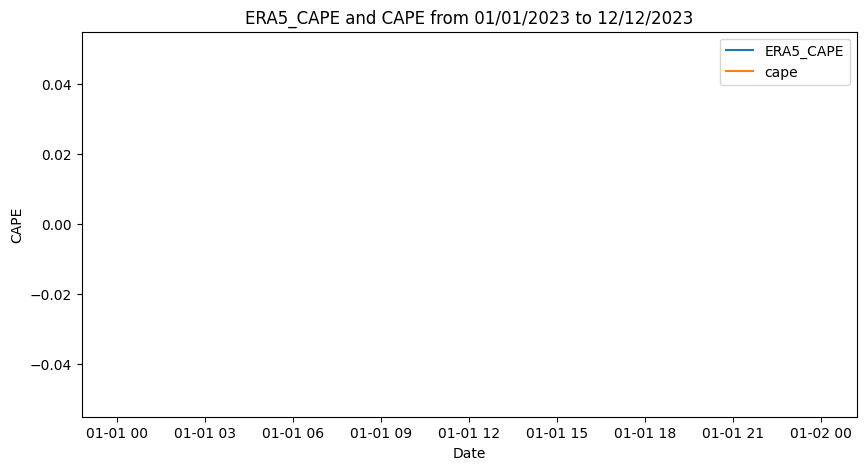

In [43]:
plot_cape_columns(df_joined)

In [52]:
import pandas as pd

# Create a sample DataFrame with a datetime64 index
dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
data = {
    'ERA5_CAPE': range(len(dates)),
    'cape': range(len(dates))
}
df = pd.DataFrame(data, index=dates)

# Define the start and end date for the period
start_date = '2023-01-01'
end_date = '2023-04-21'

# Filter the DataFrame to include only the rows within the specified date range
filtered_df = df.loc[start_date:end_date]

# Display the filtered DataFrame
print(filtered_df)


            ERA5_CAPE  cape
2023-01-01        365   365
2023-01-02        366   366
2023-01-03        367   367
2023-01-04        368   368
2023-01-05        369   369
...               ...   ...
2023-04-17        471   471
2023-04-18        472   472
2023-04-19        473   473
2023-04-20        474   474
2023-04-21        475   475

[111 rows x 2 columns]
